In [1]:
!pip install -U --pre efficientnet

     |████████████████████████████████| 51kB 4.5MB/s 


In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import tensorflow as tf
import cv2

import seaborn as sns
from PIL import Image

from tqdm import tqdm_notebook,tqdm


from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16,preprocess_input,decode_predictions
from keras.layers import  Convolution2D,MaxPooling2D,Dense,Flatten,Dropout,GlobalMaxPooling1D
from keras.layers import AveragePooling2D
from keras.models import  Sequential
import imutils
from keras.applications.resnet import ResNet50,ResNet152,preprocess_input,decode_predictions
from keras.applications.densenet import DenseNet121,DenseNet169,preprocess_input,decode_predictions
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import efficientnet.keras as efn 

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
def returnDf(path):

  train_imgs_path=pd.read_csv(path+'MURA-v1.1/train_image_paths.csv',names=['img_path'])
  test_imgs_path=pd.read_csv(path+'MURA-v1.1/valid_image_paths.csv',names=['img_path'])


  train_imgs_path['Body_Part']=train_imgs_path['img_path'].apply(lambda x: str(x.split('/')[2])[3:])
  train_imgs_path['Study_No']=train_imgs_path['img_path'].apply(lambda x: str(x.split('/')[4])[:6])
  train_imgs_path['label']=train_imgs_path['img_path'].apply(lambda x: str(x.split('/')[4])[7:])

  test_imgs_path['Body_Part']=test_imgs_path['img_path'].apply(lambda x: str(x.split('/')[2])[3:])
  test_imgs_path['Study_No']=test_imgs_path['img_path'].apply(lambda x: str(x.split('/')[4])[:6])
  test_imgs_path['label']=test_imgs_path['img_path'].apply(lambda x: str(x.split('/')[4])[7:])


  train_df=train_imgs_path
  test_df=test_imgs_path

  train_df['img_path']=[path + i for i in train_df['img_path']]
  test_df['img_path']=[path + i for i in test_df['img_path']]
  
  #train_labels['Body_Part']=train_labels['img_path'].apply(lambda x: str(x.split('/')[2])[3:])
  #train_labels['Study_Type']=train_labels['img_path'].apply(lambda x: str(x.split('/')[4])[:6])
  #test_labels['Body_Part']=test_labels['img_path'].apply(lambda x: str(x.split('/')[2])[3:])
  #test_labels['Study_Type']=test_labels['img_path'].apply(lambda x: str(x.split('/')[4])[:6])


  #train_labels['img_path']=train_imgs_path.iloc[:,0]
  #test_labels['img_path']=test_imgs_path.iloc[:,0]
    
  #train_df=train_labels[train_labels['Body_Part']==bodypart]
  #test_df=test_labels[test_labels['Body_Part']==bodypart]
  #train_df['img_path']=[path + i for i in train_df['img_path']]
  #train_df['label']=train_df['label'].astype('str')
  #test_df['img_path']=[path + i for i in test_df['img_path']]
  #test_df['label']=test_df['label'].astype('str')
  train_df['label']=[str(1) if i=='positive' else str(0) for i in train_df['label']]
  test_df['label']=[str(1) if i=='positive' else str(0) for i in test_df['label']]

  return train_df, test_df

In [5]:
train_df,test_df=returnDf('gdrive/My Drive/Capstone Medical Imaging/Data.nosync/')

In [6]:
train_df.head()

,img_path,Body_Part,Study_No,label
0,gdrive/My Drive/Capstone Medical Imaging/Data....,SHOULDER,study1,1
1,gdrive/My Drive/Capstone Medical Imaging/Data....,SHOULDER,study1,1
2,gdrive/My Drive/Capstone Medical Imaging/Data....,SHOULDER,study1,1
3,gdrive/My Drive/Capstone Medical Imaging/Data....,SHOULDER,study1,1
4,gdrive/My Drive/Capstone Medical Imaging/Data....,SHOULDER,study1,1


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36808 entries, 0 to 36807
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   img_path   36808 non-null  object
 1   Body_Part  36808 non-null  object
 2   Study_No   36808 non-null  object
 3   label      36808 non-null  object
dtypes: object(4)
memory usage: 1.1+ MB


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3197 entries, 0 to 3196
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   img_path   3197 non-null   object
 1   Body_Part  3197 non-null   object
 2   Study_No   3197 non-null   object
 3   label      3197 non-null   object
dtypes: object(4)
memory usage: 100.0+ KB


In [9]:
 train_df['img_path'].iloc[1]

'gdrive/My Drive/Capstone Medical Imaging/Data.nosync/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png'

In [10]:
train_df['Body_Part'].value_counts()

WRIST       9752
SHOULDER    8379
HAND        5543
FINGER      5106
ELBOW       4931
FOREARM     1825
HUMERUS     1272
Name: Body_Part, dtype: int64

In [11]:
test_df['Body_Part'].value_counts()

WRIST       659
SHOULDER    563
ELBOW       465
FINGER      461
HAND        460
FOREARM     301
HUMERUS     288
Name: Body_Part, dtype: int64

In [12]:
mean_imagenet = [0.485, 0.456, 0.406]
std_imagenet = [0.229, 0.224, 0.225]

In [ ]:
train_df.head().iterrows()

<generator object DataFrame.iterrows at 0x7f5166712d58>

Baseline performance is ~26.4% accuracy

5it [00:21,  4.32s/it]


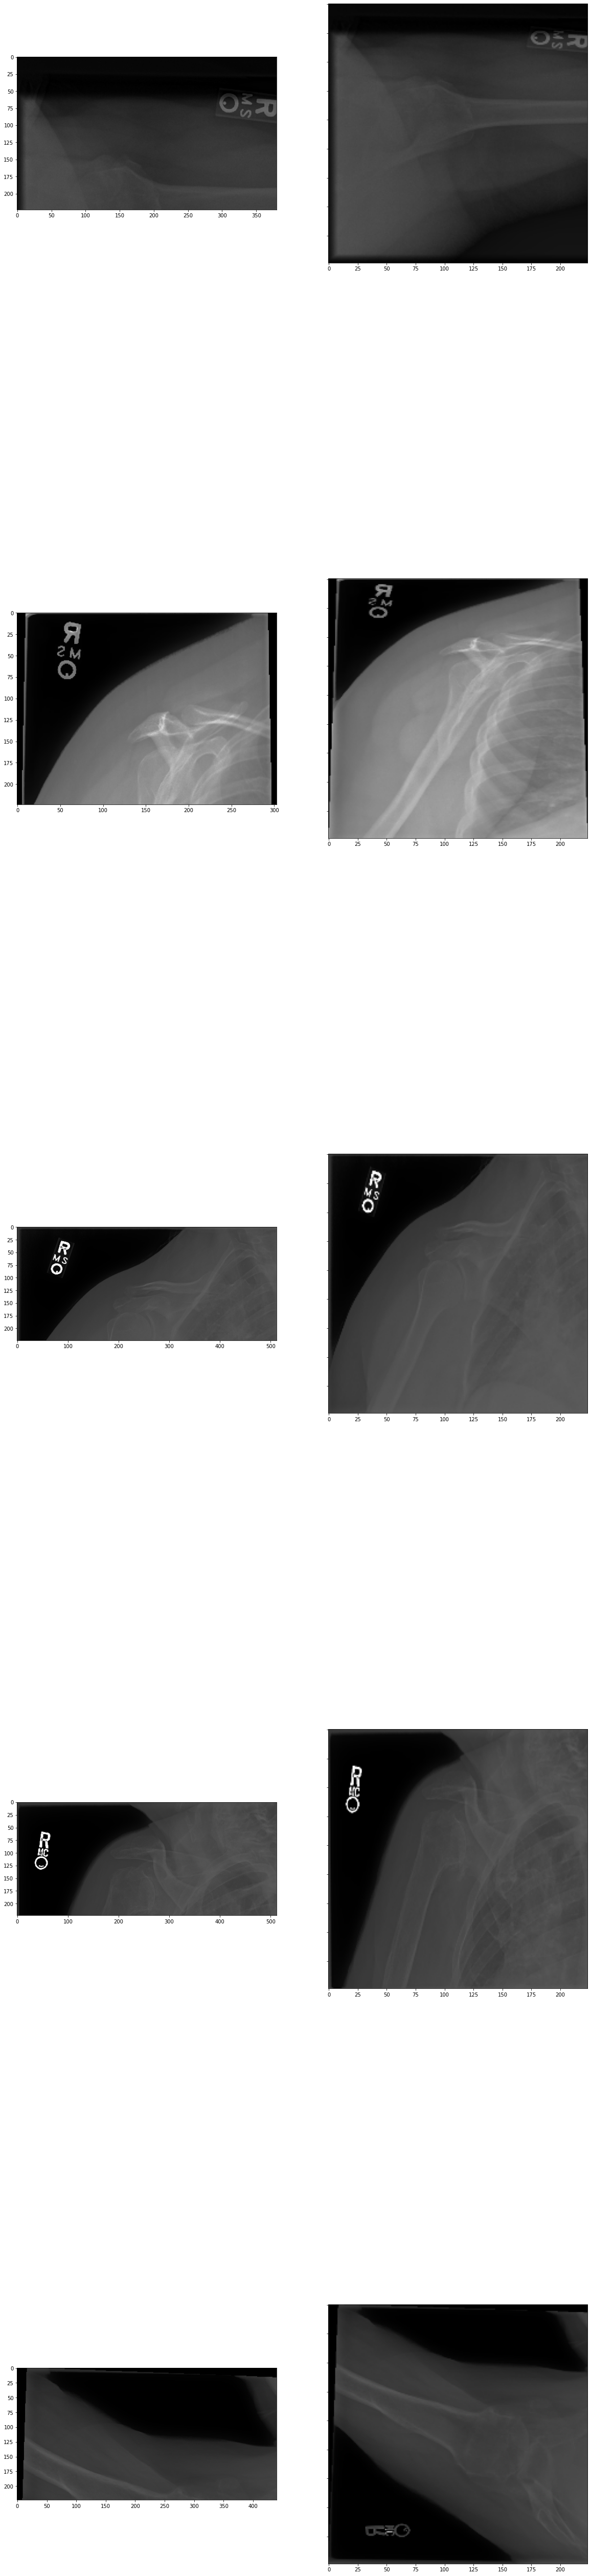

In [8]:
fig,ax=plt.subplots(5,2,sharey=True,figsize=(20,100))
image_dict={}
image_dict['images']=[]
image_dict['label']=[]
count=0
for index,row in tqdm(train_df.head().iterrows()):
  img_arr=cv2.imread(row['img_path'])
  ax[count,0].imshow(img_arr)
  
  resized_arr=cv2.resize(img_arr,(224,224))
  
  ax[count,1].imshow(resized_arr)
  count+=1
                     
  

#image_dict['images']=(image_dict['images']-mean_imagenet)/std_imagenet

In [9]:
def returnImgGen(train_df,test_df,IMG_SIZE=(224,224),rotation_range=0,horizontal_flip=False):
  datagen=ImageDataGenerator(
    horizontal_flip=horizontal_flip,
    #vertical_flip=True,
    rotation_range=rotation_range,
    #fill_mode='nearest',
    #preprocessing_function=preprocess_input)
    rescale=1./255.)



  train_gen=datagen.flow_from_dataframe(train_df,
                           x_col='img_path',
                           y_col='Body_Part',
                           target_size=IMG_SIZE,
                           color_mode='rgb',
                           class_mode='categorical',batch_size=8,seed=101)

  
    
  val_gen=datagen.flow_from_dataframe(test_df,
                           x_col='img_path',
                           y_col='Body_Part',
                           target_size=IMG_SIZE,
                           color_mode='rgb',
                           class_mode='categorical', batch_size=1,seed=101)
    
    
  return train_gen, val_gen



In [ ]:
train_gen_224,val_gen_224=returnImgGen(train_df,test_df)

Found 36808 validated image filenames belonging to 7 classes.
Found 3197 validated image filenames belonging to 7 classes.


In [10]:
def plot_val_train_loss(hist):
  loss_train = hist.history['loss']
  loss_val = hist.history['val_loss']
  epochs = range(1,len(hist.history['val_loss'])+1)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

# Performance for 224 sized images
1. Architecture: 1 conv layer(3*3) 16 filters, 1 avg pooling layer, 2 dense layers with 100 units, flatten, 1 sigmoid output layer
2. No data augmentation in data generators
3. No callbacks (no early stopping or reduction of learning rate)
4. Training: 10 epochs, default learning rate of 0.001

In [ ]:
model=Sequential()
model.add(Convolution2D(input_shape=(224,224,3),
                        kernel_size=3,
                        filters=16
                        ))
model.add(AveragePooling2D())
model.add(Dense(100))
model.add(Dense(100))
model.add(Flatten())
model.add(Dense(6, activation='softmax'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics = ['accuracy','mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
average_pooling2d (AveragePo (None, 111, 111, 16)      0         
_________________________________________________________________
dense (Dense)                (None, 111, 111, 100)     1700      
_________________________________________________________________
dense_1 (Dense)              (None, 111, 111, 100)     10100     
_________________________________________________________________
flatten (Flatten)            (None, 1232100)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1232101   
Total params: 1,244,349
Trainable params: 1,244,349
Non-trainable params: 0
______________________________________________

In [ ]:
history1=model.fit(train_gen_224,validation_data=val_gen_224,epochs=10)

Epoch 1/10
1048/1048 [==============================] - 4050s 4s/step - loss: 0.8444 - accuracy: 0.5323 - mse: 0.2749 - val_loss: 0.7778 - val_accuracy: 0.5506 - val_mse: 0.2766
Epoch 2/10
1048/1048 [==============================] - 51s 49ms/step - loss: 0.6906 - accuracy: 0.6100 - mse: 0.2415 - val_loss: 0.7409 - val_accuracy: 0.5684 - val_mse: 0.2667
Epoch 3/10
1048/1048 [==============================] - 51s 49ms/step - loss: 0.6139 - accuracy: 0.6806 - mse: 0.2089 - val_loss: 0.8178 - val_accuracy: 0.5435 - val_mse: 0.2899
Epoch 4/10
1048/1048 [==============================] - 52s 49ms/step - loss: 0.5852 - accuracy: 0.7164 - mse: 0.1924 - val_loss: 0.9442 - val_accuracy: 0.5133 - val_mse: 0.3218
Epoch 5/10
1048/1048 [==============================] - 53s 50ms/step - loss: 0.4849 - accuracy: 0.7742 - mse: 0.1566 - val_loss: 1.0632 - val_accuracy: 0.5222 - val_mse: 0.3340
Epoch 6/10
1048/1048 [==============================] - 51s 49ms/step - loss: 0.4288 - accuracy: 0.8139 - mse:

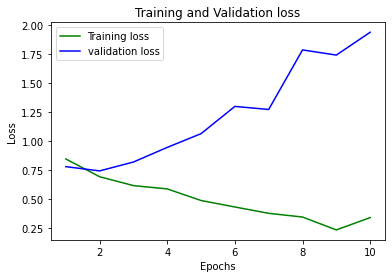

In [ ]:
plot_val_train_loss(history1)

# Performance for 224 sized images with **callbacks**, simple architecture
1. Architecture: 1 conv layer(3*3) 16 filters, 1 avg pooling layer, 2 dense layers with 100 units, flatten, 1 sigmoid output layer
2. No data augmentation in data generators
3. **Callbacks: early stopping with patience of 5, reduce lr with a factor of 0.1, patience of 3, and min_lr of 0.00001**
4. Training: 30 epochs, default initial learning rate of 0.001

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cardio_attn')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_lr=0.00001)
#epsilon=0.0001, cooldown=5
early = EarlyStopping(monitor='val_loss', patience=5, verbose=1, min_delta=1e-4) # probably needs to be more patient, but kaggle time is limited
callbacks_list_1 = [checkpoint, early, reduceLROnPlat]
model3=Sequential()
model3.add(Convolution2D(input_shape=(224,224,3),
                        kernel_size=3,
                        filters=16
                        ))
model3.add(AveragePooling2D())
model3.add(Dense(100))
model3.add(Dense(100))
model3.add(Flatten())
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy',optimizer='adam',metrics = ['accuracy','mse'])
model3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
average_pooling2d_1 (Average (None, 111, 111, 16)      0         
_________________________________________________________________
dense_3 (Dense)              (None, 111, 111, 100)     1700      
_________________________________________________________________
dense_4 (Dense)              (None, 111, 111, 100)     10100     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1232100)           0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 1232101   
Total params: 1,244,349
Trainable params: 1,244,349
Non-trainable params: 0
____________________________________________

In [ ]:
history3=model3.fit(train_gen_224,validation_data=val_gen_224,epochs=30,callbacks=callbacks_list_1)

Epoch 1/30
1048/1048 [==============================] - ETA: 0s - loss: 0.8198 - accuracy: 0.5367 - mse: 0.2776
Epoch 00001: val_loss improved from inf to 0.78926, saving model to cardio_attn_weights.best.hdf5
1048/1048 [==============================] - 53s 51ms/step - loss: 0.8198 - accuracy: 0.5367 - mse: 0.2776 - val_loss: 0.7893 - val_accuracy: 0.5062 - val_mse: 0.2904
Epoch 2/30
1048/1048 [==============================] - ETA: 0s - loss: 0.6645 - accuracy: 0.6150 - mse: 0.2334
Epoch 00002: val_loss did not improve from 0.78926
1048/1048 [==============================] - 52s 50ms/step - loss: 0.6645 - accuracy: 0.6150 - mse: 0.2334 - val_loss: 0.9284 - val_accuracy: 0.5062 - val_mse: 0.3230
Epoch 3/30
1048/1048 [==============================] - ETA: 0s - loss: 0.6528 - accuracy: 0.6658 - mse: 0.2208
Epoch 00003: val_loss improved from 0.78926 to 0.78205, saving model to cardio_attn_weights.best.hdf5
1048/1048 [==============================] - 51s 49ms/step - loss: 0.6528 - acc

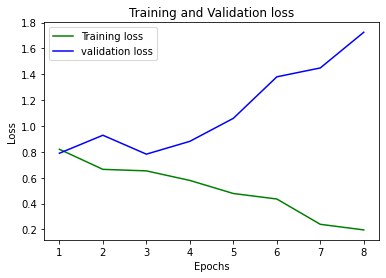

In [ ]:
plot_val_train_loss(history3)

# Performance for 224 sized images with callbacks, **stacked architecture**
1. **Architecture**: 1 conv layer(3*3) 16 filters, 1 avg pooling layer, 1 conv layer(3*3) 8 filters, 1 avg pooling layer, 2 dense layers with 100 units, flatten, 1 sigmoid output layer 
2. No data augmentation in data generators
3. Callbacks: early stopping with patience of 7, reduce lr with a factor of 0.1, patience of 3, and min_lr of 0.00001
4. Training: 30 epochs, default initial learning rate of 0.001

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
average_pooling2d_2 (Average (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 109, 109, 8)       1160      
_________________________________________________________________
average_pooling2d_3 (Average (None, 54, 54, 8)         0         
_________________________________________________________________
dense_6 (Dense)              (None, 54, 54, 100)       900       
_________________________________________________________________
dense_7 (Dense)              (None, 54, 54, 100)       10100     
_________________________________________________________________
flatten_2 (Flatten)          (None, 291600)           

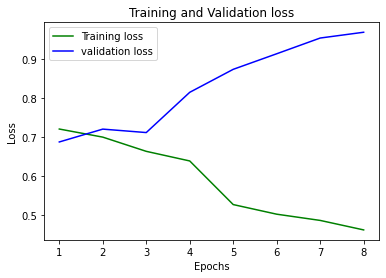

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cardio_attn')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_lr=0.00001)
#epsilon=0.0001, cooldown=5
early = EarlyStopping(monitor='val_loss', patience=7, verbose=1, min_delta=1e-4) # probably needs to be more patient, but kaggle time is limited
callbacks_list_2 = [checkpoint, early, reduceLROnPlat]

model4=Sequential()
model4.add(Convolution2D(input_shape=(224,224,3),
                        kernel_size=3,
                        filters=16
                        ))
model4.add(AveragePooling2D())
model4.add(Convolution2D(
                        kernel_size=3,
                        filters=8
                        ))
model4.add(AveragePooling2D())
model4.add(Dense(100))
model4.add(Dense(100))
model4.add(Flatten())
model4.add(Dense(1, activation='sigmoid'))
model4.compile(loss='binary_crossentropy',optimizer='adam',metrics = ['accuracy','mse'])
model4.summary()

history4=model4.fit(train_gen_224,validation_data=val_gen_224,epochs=30,callbacks=callbacks_list_2)

plot_val_train_loss(history4)

# Performance for 224 sized images with callbacks, **multiple stacked conv and pooling layers**
1. Architecture: Series of 4 conv layers with pooling layers
2. No data augmentation in data generators
3. Callbacks: early stopping with patience of 7, reduce lr with a factor of 0.1, patience of 3, and min_lr of 0.00001
4. Training: 30 epochs, default initial learning rate of 0.001

In [ ]:
model5=Sequential()
model5.add(Convolution2D(input_shape=(224,224,3),
                        kernel_size=3,
                        filters=16
                        ))
model5.add(AveragePooling2D())
model5.add(Convolution2D(input_shape=(224,224,3),
                        kernel_size=3,
                        filters=16
                        ))
model5.add(AveragePooling2D())
model5.add(Convolution2D(input_shape=(224,224,3),
                        kernel_size=3,
                        filters=16
                        ))
model5.add(AveragePooling2D())
model5.add(Convolution2D(
                        kernel_size=3,
                        filters=8
                        ))
model5.add(AveragePooling2D())
model5.add(Dense(100))
model5.add(Dense(100))
model5.add(Flatten())
model5.add(Dense(1, activation='sigmoid'))
model5.compile(loss='binary_crossentropy',optimizer='adam',metrics = ['accuracy','mse'])
model5.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
average_pooling2d_4 (Average (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 109, 109, 16)      2320      
_________________________________________________________________
average_pooling2d_5 (Average (None, 54, 54, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 52, 52, 16)        2320      
_________________________________________________________________
average_pooling2d_6 (Average (None, 26, 26, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 8)        

In [ ]:
history5=model5.fit(train_gen_224,validation_data=val_gen_224,epochs=30,callbacks=callbacks_list_2)

Epoch 1/30
1048/1048 [==============================] - ETA: 0s - loss: 0.6975 - accuracy: 0.4992 - mse: 0.2521
Epoch 00001: val_loss did not improve from 0.68742
1048/1048 [==============================] - 51s 49ms/step - loss: 0.6975 - accuracy: 0.4992 - mse: 0.2521 - val_loss: 0.6945 - val_accuracy: 0.4938 - val_mse: 0.2507
Epoch 2/30
1048/1048 [==============================] - ETA: 0s - loss: 0.6950 - accuracy: 0.5178 - mse: 0.2508
Epoch 00002: val_loss improved from 0.68742 to 0.68660, saving model to cardio_attn_weights.best.hdf5
1048/1048 [==============================] - 51s 49ms/step - loss: 0.6950 - accuracy: 0.5178 - mse: 0.2508 - val_loss: 0.6866 - val_accuracy: 0.5417 - val_mse: 0.2467
Epoch 3/30
1047/1048 [============================>.] - ETA: 0s - loss: 0.6926 - accuracy: 0.5358 - mse: 0.2495
Epoch 00003: val_loss improved from 0.68660 to 0.68257, saving model to cardio_attn_weights.best.hdf5
1048/1048 [==============================] - 53s 50ms/step - loss: 0.6926 -

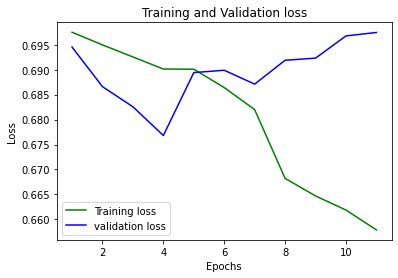

In [ ]:
plot_val_train_loss(history5)

# Performance for 224 sized images with callbacks, simple architecture with **dropout layer**
1. Architecture: 1 conv layer(3*3) 16 filters, 1 avg pooling layer, 
**1 dropout layer with 0.2 rate** , 2 dense layers with 100 units, flatten, 1 sigmoid output layer
2. No data augmentation in data generators
3. Callbacks: early stopping with patience of 7, reduce lr with a factor of 0.1, patience of 3, and min_lr of 0.00001
4. Training: 30 epochs, default initial learning rate of 0.001

In [ ]:
model6=Sequential()
model6.add(Convolution2D(input_shape=(224,224,3),
                        kernel_size=3,
                        filters=16
                        ))
model6.add(AveragePooling2D())
model6.add(Dropout(.2))
model6.add(Dense(100))
model6.add(Dense(100))
model6.add(Flatten())
model6.add(Dense(1, activation='sigmoid'))
model6.compile(loss='binary_crossentropy',optimizer='adam',metrics = ['accuracy','mse'])
model6.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
average_pooling2d_8 (Average (None, 111, 111, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 16)      0         
_________________________________________________________________
dense_12 (Dense)             (None, 111, 111, 100)     1700      
_________________________________________________________________
dense_13 (Dense)             (None, 111, 111, 100)     10100     
_________________________________________________________________
flatten_4 (Flatten)          (None, 1232100)           0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                

In [ ]:
history6=model6.fit(train_gen_224,validation_data=val_gen_224,epochs=30,callbacks=callbacks_list_2)

Epoch 1/30
1048/1048 [==============================] - ETA: 0s - loss: 0.9215 - accuracy: 0.5346 - mse: 0.2746
Epoch 00001: val_loss did not improve from 0.67681
1048/1048 [==============================] - 52s 49ms/step - loss: 0.9215 - accuracy: 0.5346 - mse: 0.2746 - val_loss: 0.7013 - val_accuracy: 0.5702 - val_mse: 0.2529
Epoch 2/30
1048/1048 [==============================] - ETA: 0s - loss: 0.6846 - accuracy: 0.6169 - mse: 0.2384
Epoch 00002: val_loss did not improve from 0.67681
1048/1048 [==============================] - 51s 49ms/step - loss: 0.6846 - accuracy: 0.6169 - mse: 0.2384 - val_loss: 0.7377 - val_accuracy: 0.4725 - val_mse: 0.2683
Epoch 3/30
1047/1048 [============================>.] - ETA: 0s - loss: 0.6362 - accuracy: 0.6623 - mse: 0.2178
Epoch 00003: val_loss did not improve from 0.67681
1048/1048 [==============================] - 51s 48ms/step - loss: 0.6362 - accuracy: 0.6623 - mse: 0.2178 - val_loss: 0.7754 - val_accuracy: 0.5435 - val_mse: 0.2739
Epoch 4/30

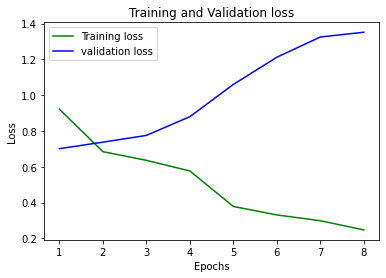

In [ ]:
plot_val_train_loss(history6)

# Performance for 224 sized images with callbacks, simple architecture, with **activation relu**
1. Architecture: 1 conv layer(3*3) 64 filters with 
**activation**, 1 avg pooling layer, 1, 2 dense layers with 100 units, flatten, 1 sigmoid output layer
2. No data augmentation in data generators
3. Callbacks: early stopping with patience of 7, reduce lr with a factor of 0.1, patience of 3, and min_lr of 0.00001
4. Training: 30 epochs, default initial learning rate of 0.001

In [ ]:
model7=Sequential()
model7.add(Convolution2D(input_shape=(224,224,3),
                        kernel_size=3,
                      filters=64,activation='relu'
                        ))
model7.add(AveragePooling2D())
#model7.add(Dropout(.2))
model7.add(Dense(100))
model7.add(Dense(100))
model7.add(Flatten())
model7.add(Dense(1, activation='sigmoid'))
model7.compile(loss='binary_crossentropy',optimizer='adam',metrics = ['accuracy','mse'])
model7.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 222, 222, 64)      1792      
_________________________________________________________________
average_pooling2d_9 (Average (None, 111, 111, 64)      0         
_________________________________________________________________
dense_15 (Dense)             (None, 111, 111, 100)     6500      
_________________________________________________________________
dense_16 (Dense)             (None, 111, 111, 100)     10100     
_________________________________________________________________
flatten_5 (Flatten)          (None, 1232100)           0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 1232101   
Total params: 1,250,493
Trainable params: 1,250,493
Non-trainable params: 0
____________________________________________

In [ ]:
history7=model7.fit(train_gen_224,validation_data=val_gen_224,epochs=30,callbacks=callbacks_list_2,shuffle=True,use_multiprocessing=True)

Epoch 1/30
1048/1048 [==============================] - ETA: 0s - loss: 0.7654 - accuracy: 0.5519 - mse: 0.2624WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00001: val_loss did not improve from 0.67681
1048/1048 [==============================] - 60s 58ms/step - loss: 0.7654 - accuracy: 0.5519 - mse: 0.2624 - val_loss: 0.7015 - val_accuracy: 0.5737 - val_mse: 0.2502
Epoch 2/30
1048/1048 [==============================] - ETA: 0s - loss: 0.6843 - accuracy: 0.6226 - mse: 0.2377WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00002: val_loss did not improve from 0.67681
1048/1048 [==============================] - 62s 59ms/step - loss: 0.6843 - accuracy: 0.6226 - mse: 0.2377 - val_loss: 0.7385 - val_accuracy: 0.5346 - val_mse: 0.2649
Epoch 

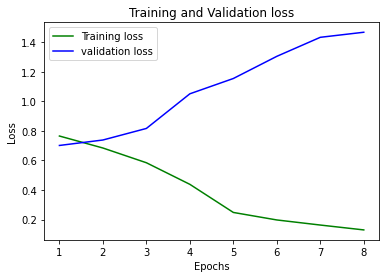

In [ ]:
plot_val_train_loss(history7)

# Performance for 224 sized images with callbacks, simple architecture, with activation relu, **maxpooling**
1. Architecture: 1 conv layer(3*3) 64 filters with activation, 1 avg pooling layer, 1, 2 dense layers with 100 units, flatten, 1 sigmoid output layer
2. No data augmentation in data generators
3. Callbacks: early stopping with patience of 7, reduce lr with a factor of 0.1, patience of 3, and min_lr of 0.00001
4. Training: 30 epochs, default initial learning rate of 0.001

In [ ]:
model8=Sequential()
model8.add(Convolution2D(input_shape=(224,224,3),
                        kernel_size=3,
                      filters=64,activation='relu'
                        ))
model8.add(MaxPooling2D())
#model8.add(Dropout(.2))
model8.add(Dense(100))
model8.add(Dense(100))
model8.add(Flatten())
model8.add(Dense(1, activation='sigmoid'))
model8.compile(loss='binary_crossentropy',optimizer='adam',metrics = ['accuracy','mse'])
model8.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
dense_18 (Dense)             (None, 111, 111, 100)     6500      
_________________________________________________________________
dense_19 (Dense)             (None, 111, 111, 100)     10100     
_________________________________________________________________
flatten_6 (Flatten)          (None, 1232100)           0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 1232101   
Total params: 1,250,493
Trainable params: 1,250,493
Non-trainable params: 0
____________________________________________

In [ ]:
history8=model8.fit(train_gen_224,validation_data=val_gen_224,epochs=10,callbacks=callbacks_list_2,shuffle=True)

Epoch 1/10
1048/1048 [==============================] - ETA: 0s - loss: 0.7988 - accuracy: 0.5641 - mse: 0.2577
Epoch 00001: val_loss improved from 0.67681 to 0.67669, saving model to cardio_attn_weights.best.hdf5
1048/1048 [==============================] - 51s 49ms/step - loss: 0.7988 - accuracy: 0.5641 - mse: 0.2577 - val_loss: 0.6767 - val_accuracy: 0.5968 - val_mse: 0.2414
Epoch 2/10
1048/1048 [==============================] - ETA: 0s - loss: 0.6212 - accuracy: 0.6674 - mse: 0.2124
Epoch 00002: val_loss did not improve from 0.67669
1048/1048 [==============================] - 51s 49ms/step - loss: 0.6212 - accuracy: 0.6674 - mse: 0.2124 - val_loss: 0.8466 - val_accuracy: 0.5044 - val_mse: 0.3054
Epoch 3/10
1047/1048 [============================>.] - ETA: 0s - loss: 0.5054 - accuracy: 0.7702 - mse: 0.1594
Epoch 00003: val_loss did not improve from 0.67669
1048/1048 [==============================] - 50s 48ms/step - loss: 0.5052 - accuracy: 0.7703 - mse: 0.1594 - val_loss: 0.9121 

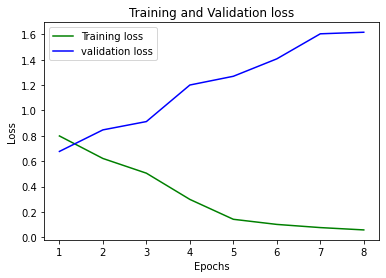

In [ ]:
plot_val_train_loss(history8)

# Performance for 224 sized images with callbacks, simple architecture, with activation relu, maxpooling, with **dropout layer of 0.5**
1. Architecture: 1 conv layer(3*3) 64 filters with activation, 1 avg pooling layer, 1 dropout layer with 0.5 rate, 2 dense layers with 100 units, flatten, 1 sigmoid output layer
2. No data augmentation in data generators
3. Callbacks: early stopping with patience of 7, reduce lr with a factor of 0.1, patience of 3, and min_lr of 0.00001
4. Training: 30 epochs, default initial learning rate of 0.0001

In [ ]:
opt=keras.optimizers.Adam(learning_rate=0.0001)
model9=Sequential()
model9.add(Convolution2D(input_shape=(224,224,3),
                        kernel_size=3,
                      filters=64,activation='relu'
                        ))
model9.add(MaxPooling2D())
model9.add(Dropout(.5))
model9.add(Dense(100))
model9.add(Dense(100))
model9.add(Flatten())
model9.add(Dense(1, activation='sigmoid'))
model9.compile(loss='binary_crossentropy',optimizer=opt,metrics = ['accuracy','mse'])
model9.summary()

history9=model9.fit(train_gen_224,validation_data=val_gen_224,epochs=20,callbacks=callbacks_list_2,shuffle=True)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 111, 111, 64)      0         
_________________________________________________________________
dense_21 (Dense)             (None, 111, 111, 100)     6500      
_________________________________________________________________
dense_22 (Dense)             (None, 111, 111, 100)     10100     
_________________________________________________________________
flatten_7 (Flatten)          (None, 1232100)           0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                

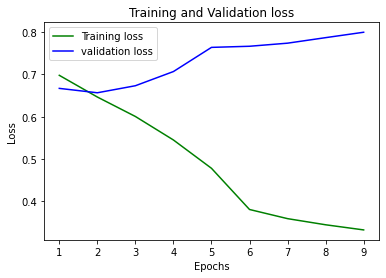

In [ ]:
plot_val_train_loss(history9)

# Performance for 224 sized images with callbacks, **2 blocks of convd, pool, dropout**
1. Architecture: (1 conv layer(3*3) 64 filters with activation, 1 avg pooling layer, 1 dropout layer with 0.5 rate)*2, 2 dense layers with 100 units, flatten, 1 sigmoid output layer
2. No data augmentation in data generators
3. Callbacks: early stopping with patience of 7, reduce lr with a factor of 0.1, patience of 3, and min_lr of 0.00001
4. Training: 30 epochs, default initial learning rate of 0.001

In [ ]:
opt=keras.optimizers.Adam(learning_rate=0.001)
model10=Sequential()
model10.add(Convolution2D(input_shape=(224,224,3),
                        kernel_size=3,
                      filters=64,activation='relu'
                        ))
model10.add(MaxPooling2D())
model10.add(Dropout(.5))
model10.add(Convolution2D(kernel_size=3,
                      filters=64,activation='relu'
                        ))
model10.add(MaxPooling2D())
model10.add(Dropout(.5))
model10.add(Dense(100))
model10.add(Dense(100))
model10.add(Flatten())
model10.add(Dense(1, activation='sigmoid'))
model10.compile(loss='binary_crossentropy',optimizer=opt,metrics = ['accuracy','mse'])
model10.summary()

history10=model10.fit(train_gen_224,validation_data=val_gen_224,epochs=20,callbacks=callbacks_list_2,shuffle=True)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 64)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 54, 54, 64)        0         
_________________________________________________________________
dense_24 (Dense)             (None, 54, 54, 100)      

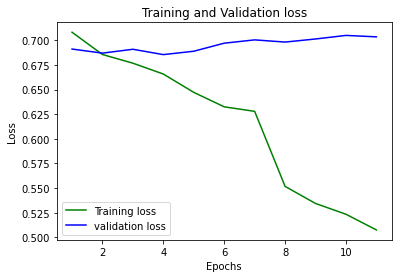

In [ ]:
plot_val_train_loss(history10)

# Testing smaller learning decay
1. Architecture: (1 conv layer(3*3) 64 filters with activation, 1 avg pooling layer, 1 dropout layer with 0.5 rate)*2, 2 dense layers with 100 units, flatten, 1 sigmoid output layer
2. No data augmentation in data generators
3. Callbacks: early stopping with patience of 7, reduce lr with a factor of 0.5, patience of 3, and min_lr of 0.00001
4. Training: 30 epochs, default initial learning rate of **0.001**

In [ ]:
weight_path="{}_weights.best.hdf5".format('cardio_attn')

checkpoint3 = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat3 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='auto', min_lr=0.000001)
#epsilon=0.0001, cooldown=5
early3 = EarlyStopping(monitor='val_loss', patience=7, verbose=1, min_delta=1e-4) # probably needs to be more patient, but kaggle time is limited
callbacks_list_3 = [checkpoint3, early3, reduceLROnPlat3]

opt=keras.optimizers.Adam(learning_rate=0.001)
model11=Sequential()
model11.add(Convolution2D(input_shape=(224,224,3),
                        kernel_size=3,
                      filters=64,activation='relu'
                        ))
model11.add(MaxPooling2D())
model11.add(Dropout(.5))
model11.add(Convolution2D(kernel_size=3,
                      filters=64,activation='relu'
                        ))
model11.add(MaxPooling2D())
model11.add(Dropout(.5))
model11.add(Dense(100))
model11.add(Dense(100))
model11.add(Flatten())
model11.add(Dense(1, activation='sigmoid'))
model11.compile(loss='binary_crossentropy',optimizer=opt,metrics = ['accuracy','mse'])
model11.summary()

history11=model11.fit(train_gen_224,validation_data=val_gen_224,epochs=20,callbacks=callbacks_list_3,shuffle=True)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 64)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 54, 54, 64)        0         
_________________________________________________________________
dense_27 (Dense)             (None, 54, 54, 100)      

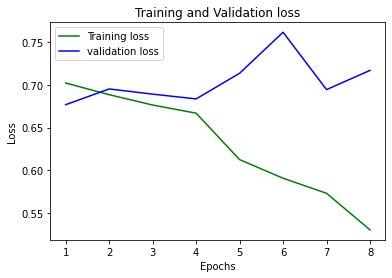

In [ ]:
plot_val_train_loss(history11)

# Made second block with tanh activation
1. Architecture: (1 conv layer(3*3) 64 filters with activation, 1 avg pooling layer, 1 dropout layer with 0.5 rate)*2, 2 dense layers with 100 units, flatten, 1 sigmoid output layer
2. No data augmentation in data generators
3. Callbacks: early stopping with patience of 7, reduce lr with a factor of 0.5, patience of 3, and min_lr of 0.00001
4. Training: 30 epochs, default initial learning rate of **0.001**

In [ ]:
weight_path="{}_weights.best.hdf5".format('cardio_attn')

checkpoint3 = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat3 = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_lr=0.000001)
#epsilon=0.0001, cooldown=5
early3 = EarlyStopping(monitor='val_loss', patience=7, verbose=1, min_delta=1e-4) # probably needs to be more patient, but kaggle time is limited
callbacks_list_3 = [checkpoint3, early3, reduceLROnPlat3]

opt=keras.optimizers.Adam(learning_rate=0.001)
model12=Sequential()
model12.add(Convolution2D(input_shape=(224,224,3),
                        kernel_size=3,
                      filters=64,activation='relu'
                        ))
model12.add(MaxPooling2D())
model12.add(Dropout(.5))
model12.add(Convolution2D(kernel_size=3,
                      filters=64,activation='tanh'
                        ))
model12.add(MaxPooling2D())
model12.add(Dropout(.5))
model12.add(Dense(100))
model12.add(Dense(100))
model12.add(Flatten())
model12.add(Dense(1, activation='sigmoid'))
model12.compile(loss='binary_crossentropy',optimizer=opt,metrics = ['accuracy','mse'])
model12.summary()

history12=model12.fit(train_gen_224,validation_data=val_gen_224,epochs=20,callbacks=callbacks_list_3,shuffle=True)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 111, 111, 64)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 54, 54, 64)        0         
_________________________________________________________________
dense_30 (Dense)             (None, 54, 54, 100)     

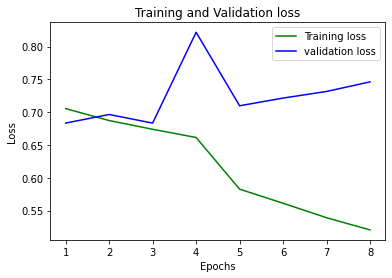

In [ ]:
plot_val_train_loss(history12)

# Made three blocks
1. Architecture: 3 blocks of convd and pooling and dropout
2. No data augmentation in data generators
3. Callbacks: early stopping with patience of 7, reduce lr with a factor of 0.5, patience of 3, and min_lr of 0.00001
4. Training: 30 epochs, default initial learning rate of **0.001**

In [ ]:
weight_path="{}_weights.best.hdf5".format('cardio_attn')

checkpoint3 = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat3 = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_lr=0.000001)
#epsilon=0.0001, cooldown=5
early3 = EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=1e-4) # probably needs to be more patient, but kaggle time is limited
callbacks_list_3 = [checkpoint3, early3, reduceLROnPlat3]

opt=keras.optimizers.Adam(learning_rate=0.001)
model13=Sequential()
model13.add(Convolution2D(input_shape=(224,224,3),
                        kernel_size=3,
                      filters=64,activation='relu'
                        ))
model13.add(MaxPooling2D())
model13.add(Dropout(.5))
model13.add(Convolution2D(kernel_size=3,
                      filters=64,activation='tanh'
                        ))
model13.add(MaxPooling2D())
model13.add(Dropout(.5))
model13.add(Convolution2D(kernel_size=1,
                      filters=64,activation='relu'
                        ))
model13.add(AveragePooling2D())
model13.add(Dropout(.5))
model13.add(Dense(100))
model13.add(Dense(100))
model13.add(Flatten())
model13.add(Dense(1, activation='sigmoid'))
model13.compile(loss='binary_crossentropy',optimizer=opt,metrics = ['accuracy','mse'])
model13.summary()

history13=model13.fit(train_gen_224,validation_data=val_gen_224,epochs=20,callbacks=callbacks_list_3,shuffle=True)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 111, 111, 64)      0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 54, 54, 64)      

# DenseNet 169 

In [1]:
weight_path="{}_weights.best.hdf5".format('best_densenet_body_part_detector')

checkpoint3 = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat3 = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_lr=0.000001)
#epsilon=0.0001, cooldown=5
early3 = EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=1e-4) # probably needs to be more patient, but kaggle time is limited
callbacks_list_3 = [checkpoint3, early3, reduceLROnPlat3]

opt=keras.optimizers.Adam(learning_rate=0.001) #change to 0.01
model14=Sequential()
model14.add(DenseNet169(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg'))
model14.add(Flatten())
model14.add(Dense(7, activation='softmax'))
model14.compile(loss='binary_crossentropy',optimizer=opt,metrics = ['accuracy','mse'])
model14.summary()

history14=model14.fit(train_gen_224,validation_data=val_gen_224,epochs=30,callbacks=callbacks_list_3,shuffle=True)

NameError: ignored

In [ ]:
plot_val_train_loss(history14)

NameError: ignored

Decent performance, so lets try augmentation? flipping and rotation as well as some other complex models

# Resnet

In [ ]:
weight_path="{}_weights.best.hdf5".format('cardio_attn')

checkpoint3 = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat3 = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_lr=0.0001)
#epsilon=0.0001, cooldown=5
early3 = EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=1e-4) # probably needs to be more patient, but kaggle time is limited
callbacks_list_3 = [checkpoint3, early3, reduceLROnPlat3]

opt=keras.optimizers.Adam(learning_rate=0.001)
model15=Sequential()
model15.add(ResNet152(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg'))
model15.add(Flatten())
model15.add(Dense(7, activation='softmax'))
model15.compile(loss='binary_crossentropy',optimizer=opt,metrics = ['accuracy','mse'])
model15.summary()

history15=model15.fit(train_gen_224,validation_data=val_gen_224,epochs=100,callbacks=callbacks_list_3,shuffle=True)

234700800/234698864 [==============================] - 5s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, 2048)              58370944  
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 14343     
Total params: 58,385,287
Trainable params: 58,233,863
Non-trainable params: 151,424
_________________________________________________________________
Epoch 1/100
4601/4601 [==============================] - ETA: 0s - loss: 0.2700 - accuracy: 0.5641 - mse: 0.0774
Epoch 00001: val_loss improved from inf to 0.59387, saving model to cardio_attn_weights.best.hdf5
4601/4601 [==============================] - 784s 170ms/step - loss: 0.2700 - accuracy: 

In [ ]:
plot_val_train_loss(history15)

# Augmentation Data Generators

In [12]:
train_gen_aug,val_gen_aug=returnImgGen(train_df,test_df,IMG_SIZE=(224,224),rotation_range=30,horizontal_flip=True)

Found 36808 validated image filenames belonging to 7 classes.
Found 3197 validated image filenames belonging to 7 classes.


In [13]:
weight_path="{}_weights.best.hdf5".format('best_densenet_bodypart_classifier')

checkpoint3 = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat3 = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_lr=0.000001)
#epsilon=0.0001, cooldown=5
early3 = EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=1e-4) # probably needs to be more patient, but kaggle time is limited
callbacks_list_3 = [checkpoint3, early3, reduceLROnPlat3]

opt=keras.optimizers.Adam(learning_rate=0.001)
model17=Sequential()
model17.add(DenseNet169(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg'))
model17.add(Flatten())
model17.add(Dense(7, activation='softmax'))
model17.compile(loss='binary_crossentropy',optimizer=opt,metrics = ['accuracy','mse'])
model17.summary()

history17=model17.fit(train_gen_aug,validation_data=val_gen_aug,epochs=30,callbacks=callbacks_list_3,shuffle=True)

51879936/51877672 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 1664)              12642880  
_________________________________________________________________
flatten (Flatten)            (None, 1664)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 11655     
Total params: 12,654,535
Trainable params: 12,496,135
Non-trainable params: 158,400
_________________________________________________________________
Epoch 1/30
4601/4601 [==============================] - ETA: 0s - loss: 0.1224 - accuracy: 0.8317 - mse: 0.0340
Epoch 00001: val_loss improved from inf to 0.12404, saving model to best_densenet_bodypart_classifier_weights.best.hdf5
4601/4601 [==============================] - 18322s 4s/step - loss: 0.1

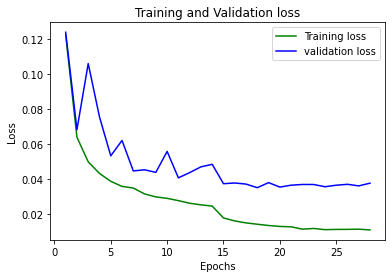

In [14]:
plot_val_train_loss(history17)

In [15]:
from google.colab import files
files.download("best_densenet_bodypart_classifier_weights.best.hdf5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
print('Confusion Matrix')
print(confusion_matrix(val_gen_aug.classes, predictions))
print('Classification Report')
target_names = ['Normal','Abnormal']
print(classification_report(val_gen_aug.classes, predictions, target_names=target_names))

Confusion Matrix


NameError: ignored

In [ ]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(val_gen_aug.classes, predictions)

In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0.0, 0.2)
plt.ylim(0.65, 0.9)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

# Efficientnet with Augmentation

In [ ]:
weight_path="{}_weights.best.hdf5".format('best_efficientnet0_bodypart_classifier')

checkpoint3 = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat3 = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_lr=0.000001)
#epsilon=0.0001, cooldown=5
early3 = EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=1e-4) # probably needs to be more patient, but kaggle time is limited
callbacks_list_3 = [checkpoint3, early3, reduceLROnPlat3]

opt=keras.optimizers.Adam(learning_rate=0.001)
model19=Sequential()
model19.add(efn.EfficientNetB0(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg'))
model19.add(Flatten())
model19.add(Dense(1, activation='sigmoid'))
model19.compile(loss='binary_crossentropy',optimizer=opt,metrics = ['accuracy','mse'])
model19.summary()

history19=model19.fit(train_gen_aug,validation_data=val_gen_aug,epochs=30,callbacks=callbacks_list_3,shuffle=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 1280)              4049564   
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 4,050,845
Trainable params: 4,008,829
Non-trainable params: 42,016
_________________________________________________________________
Epoch 1/30
1468/4601 [========>.....................] - ETA: 3:16:28 - loss: 0.4118 - accuracy: 0.8568 - mse: 0.1229

In [ ]:
from google.colab import files
files.download("best_efficientnet0_bodypart_classifier_weights.best.hdf5")